In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, log_loss

import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Load context dataset
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/contextXGBoost.csv')

In [ ]:
# Sort for feature engineering
if 'game_pk' in df.columns and 'at_bat_number' in df.columns and 'pitch_number' in df.columns:
    df.sort_values(by=['game_pk', 'at_bat_number', 'pitch_number'], inplace=True)

# Create Target
df['target'] = df['pitch_type'] + "_" + df['zone'].astype(str)

# Pitch Type Lags
df['prev_pitch_type'] = df.groupby('game_pk')['pitch_type'].transform(lambda x: x.shift(1).fillna('None'))
df['prev2_pitch_type'] = df.groupby('game_pk')['pitch_type'].transform(lambda x: x.shift(2).fillna('None'))

# Zone Lags
# We fill with 'None' (string) to handle the start of the game
df['prev_zone'] = df.groupby('game_pk')['zone'].transform(lambda x: x.shift(1).fillna('None'))
df['prev2_zone'] = df.groupby('game_pk')['zone'].transform(lambda x: x.shift(2).fillna('None'))

# Outcome Lags (Statcast 'events', 'description', 'type')
df['prev_event'] = df.groupby('game_pk')['events'].transform(lambda x: x.shift(1).fillna('None'))
df['prev_desc'] = df.groupby('game_pk')['description'].transform(lambda x: x.shift(1).fillna('None'))
df['prev_type'] = df.groupby('game_pk')['type'].transform(lambda x: x.shift(1).fillna('None')) # S/B/X

# Performance Lags
df['prev_exit_velo'] = df.groupby('game_pk')['launch_speed'].transform(lambda x: x.shift(1).fillna(0))
df['prev_distance'] = df.groupby('game_pk')['hit_distance_sc'].transform(lambda x: x.shift(1).fillna(0))
df['prev_was_hard_hit'] = (df['prev_exit_velo'] > 95).astype(int)

df['prev_plate_x'] = df.groupby('game_pk')['plate_x'].transform(lambda x: x.shift(1).fillna(0))
df['prev_plate_z'] = df.groupby('game_pk')['plate_z'].transform(lambda x: x.shift(1).fillna(2.5))
df['prev_dist_center'] = np.sqrt(df['prev_plate_x']**2 + (df['prev_plate_z']-2.5)**2)

# Rolling Trends
def get_rolling_stats(series, window=5):
    return series.shift(1).rolling(window=window, min_periods=1).mean()

df['roll_avg_release_speed'] = df.groupby('game_pk')['release_speed'].transform(lambda x: get_rolling_stats(x, window=5)).fillna(0)
df['roll_avg_pfx_z'] = df.groupby('game_pk')['pfx_z'].transform(lambda x: get_rolling_stats(x, window=5)).fillna(0)


# Clean Context Features
for r in ['1b', '2b', '3b']:
    if f'on_{r}' in df.columns:
        df[f'runner_{r}'] = df[f'on_{r}'].notna().astype(int)
    else:
        df[f'runner_{r}'] = 0

if 'bat_score_diff' in df.columns:
    df['score_diff'] = df['bat_score_diff']
elif 'fld_score' in df.columns and 'bat_score' in df.columns:
    df['score_diff'] = df['fld_score'] - df['bat_score']
else:
    df['score_diff'] = 0

features = [
    # Context
    'balls', 'strikes', 'outs_when_up', 'inning', 'score_diff',
    'runner_1b', 'runner_2b', 'runner_3b',

    # Matchup
    'stand', 'fielder_2', 'if_fielding_alignment', 'of_fielding_alignment', 'inning_topbot',

    # Fatigue / Counts
    'pitch_number', 'at_bat_number', 'n_thruorder_pitcher', 'pitcher_days_since_prev_game',

    # Rolling Trends
    'roll_avg_release_speed', 'roll_avg_pfx_z',

    # Categorical Lags (History)
    'prev_pitch_type', 'prev2_pitch_type',
    'prev_zone', 'prev2_zone',  # <--- Added Here
    'prev_event', 'prev_desc', 'prev_type',

    # Numeric Lags
    'prev_exit_velo', 'prev_distance', 'prev_was_hard_hit',
    'prev_plate_x', 'prev_plate_z', 'prev_dist_center',

    # Target
    'target'
]

df_final = df[features].copy()

# Convert numeric categorical IDs to string
# This is crucial for 'zone' so '1' doesn't relate mathematically to '9'
if 'fielder_2' in df_final.columns:
    df_final['fielder_2'] = df_final['fielder_2'].astype(str)

df_final['prev_zone'] = df_final['prev_zone'].astype(str)
df_final['prev2_zone'] = df_final['prev2_zone'].astype(str)

# One-Hot Encode Categorical Inputs
cols_to_one_hot = [
    'stand', 'fielder_2', 'inning_topbot',
    'if_fielding_alignment', 'of_fielding_alignment',
    'prev_event', 'prev_desc', 'prev_type',
    'prev_pitch_type', 'prev2_pitch_type',
    'prev_zone', 'prev2_zone'
]

# Check which exist before encoding
cols_to_encode = [c for c in cols_to_one_hot if c in df_final.columns]
df_encoded = pd.get_dummies(df_final, columns=cols_to_encode, drop_first=True)

# Label Encode Target
le = LabelEncoder()
df_encoded['target_id'] = le.fit_transform(df_encoded['target'])

# Drop the text target
df_ready = df_encoded.drop(columns=['target'])

# Save
df_ready.to_csv('Skenes_Stage2_Encoded.csv', index=False)

print("Stage 2 Data Ready.")
print(f"Total Features: {len(df_ready.columns)}")
print(f"Target Encoded as: 'target_id'")
print(f"Columns (First 20): {df_ready.columns.tolist()[:20]}")

Stage 2 Data Ready.
Total Features: 98
Target Encoded as: 'target_id'
Columns (First 20): ['balls', 'strikes', 'outs_when_up', 'inning', 'score_diff', 'runner_1b', 'runner_2b', 'runner_3b', 'pitch_number', 'at_bat_number', 'n_thruorder_pitcher', 'pitcher_days_since_prev_game', 'roll_avg_release_speed', 'roll_avg_pfx_z', 'prev_exit_velo', 'prev_distance', 'prev_was_hard_hit', 'prev_plate_x', 'prev_plate_z', 'prev_dist_center']



--- Split Summary ---
Training Set: 2329 pitches (The Past)
Testing Set:  583 pitches (The Future)

Training Context Model...

---------------------------------------
CONTEXT MODEL ACCURACY: 0.0652
---------------------------------------


<Figure size 1000x800 with 0 Axes>

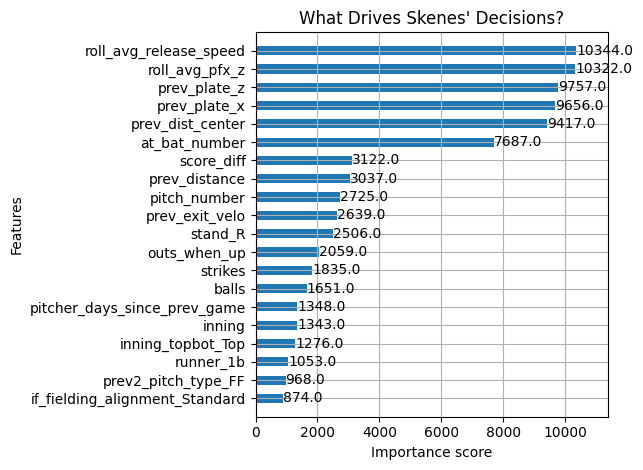

Results exported to 'Skenes_Context_Model_Results.csv'


In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# drop the target_id to create Feature Matrix (X)
X = df_ready.drop(columns=['target_id'])
y = df_ready['target_id']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"\n--- Split Summary ---")
print(f"Training Set: {len(X_train)} pitches (The Past)")
print(f"Testing Set:  {len(X_test)} pitches (The Future)")

print("\nTraining Context Model...")

temp_le_train = LabelEncoder()
y_train_encoded = temp_le_train.fit_transform(y_train)

# Number of classes for the model should be the number of unique classes in the training set
num_classes_in_train = len(y_train.unique())

model = xgb.XGBClassifier(
    objective='multi:softmax',  # Standard multiclass classification
    num_class=num_classes_in_train,      # Dynamically set total numof Pitch_Zone combinations using LabelEncoder
    n_estimators=200,           # Number of trees
    max_depth=4,                # Shallow depth to prevent overfitting on small data
    learning_rate=0.05,         # Slow learning rate for robustness
    subsample=0.8,              # Use 80% of rows per tree
    colsample_bytree=0.8,       # Use 80% of columns per tree
    random_state=42,
)

model.fit(
    X_train, y_train_encoded,
)

# Make predictions on the "Future" data
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)

print(f"\n---------------------------------------")
print(f"CONTEXT MODEL ACCURACY: {accuracy:.4f}")
print(f"---------------------------------------")

# This graph shows which features actually drive the decisions.
# Watch for 'prev_pitch_type' or 'prev_zone' appearing near the top.


plt.figure(figsize=(10, 8))
xgb.plot_importance(model, max_num_features=20, height=0.5, importance_type='weight', title='What Drives Skenes\' Decisions?')
plt.tight_layout()
plt.show()

# Save the test results to compare against your Baseline Matrix later.
results_df = X_test.copy()
results_df['Actual_ID'] = y_test
results_df['Predicted_ID'] = predictions
results_df['Actual_Label'] = le.inverse_transform(y_test)
results_df['Predicted_Label'] = le.inverse_transform(predictions)

results_df.to_csv('Skenes_Context_Model_Results.csv', index=False)
print("Results exported to 'Skenes_Context_Model_Results.csv'")